Please upload your CSV file (if not already uploaded):
Columns in dataset: ['DATE', 'IPG2211A2N']
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - loss: 0.1835 - val_loss: 0.2797
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1096 - val_loss: 0.1016
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0312 - val_loss: 0.0241
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - val_loss: 0.0450
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0217 - val_loss: 0.0372
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0194 - val_loss: 0.0251
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0156 - val_loss: 0.0277
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0240
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0149 - val_loss: 0.0238
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0145 - val_loss: 0.0233
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0139 - val_loss: 0.0231
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0147 - val_loss: 0.0231
Epoch 13/50

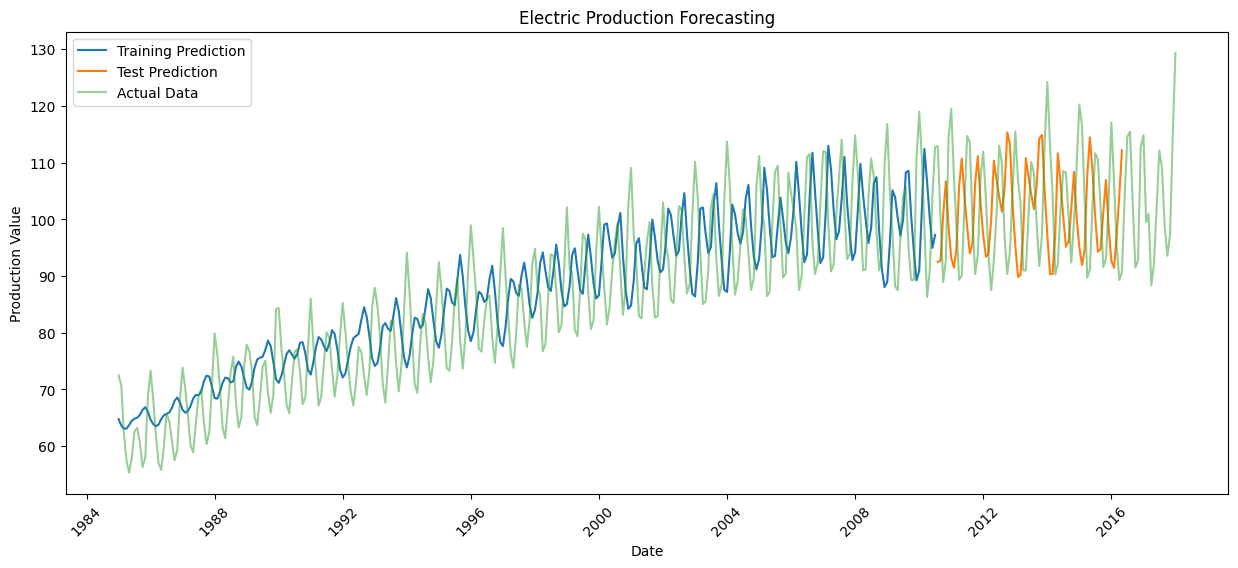

Train RMSE: 6.1813
Test RMSE: 7.0924


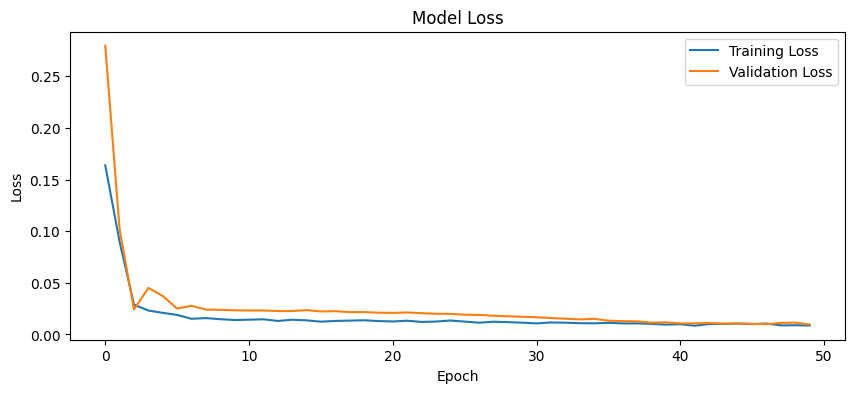

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from google.colab import files

# 1. Upload your dataset (already done in your case)
print("Please upload your CSV file (if not already uploaded):")
# uploaded = files.upload()  # Comment this out since you've already uploaded

# Load the dataset
filename = 'Electric_Production.csv'  # Use the original filename
df = pd.read_csv(filename)

# 2. Prepare the data
# Adjust these column names based on your actual dataset
date_column = 'DATE'  # Common in electric production datasets
value_column = 'IPG2211A2N'  # Typical FRED dataset column; adjust if different

# Check if columns exist (for debugging)
print("Columns in dataset:", df.columns.tolist())

# Convert date column to datetime
df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)

# Extract the time series data
time_series = df[value_column].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# 3. Create sequences for time series
def prepare_data(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        seq = series[i:(i + n_steps)]
        X.append(seq)
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

# Parameters
n_steps = 10  # Number of time steps to look back (adjust as needed)
train_size = int(len(scaled_data) * 0.8)

# Split into train and test
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare training and testing data
X_train, y_train = prepare_data(train_data, n_steps)
X_test, y_test = prepare_data(test_data, n_steps)

# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 4. Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# 5. Train the model
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# 6. Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Visualize results
plt.figure(figsize=(15, 6))
plt.plot(df.index[:len(train_predict)], train_predict, label='Training Prediction')
plt.plot(df.index[len(train_predict):len(train_predict) + len(test_predict)],
         test_predict, label='Test Prediction')
plt.plot(df.index, time_series, label='Actual Data', alpha=0.5)
plt.legend()
plt.title('Electric Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Production Value')
plt.xticks(rotation=45)
plt.show()

# 8. Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Please upload your CSV file (if not already uploaded):
Columns in dataset: ['DATE', 'IPG2211A2N']
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - loss: 0.1749 - val_loss: 0.3619
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1578 - val_loss: 0.3299
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1388 - val_loss: 0.2927
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1178 - val_loss: 0.2506
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0948 - val_loss: 0.2030
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0707 - val_loss: 0.1515
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0494 - val_loss: 0.1008
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0324 - val_loss: 0.0595
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0240 - val_loss: 0.0350
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214 - val_loss: 0.0271
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0222 - val_loss: 0.0282
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211 - val_loss: 0.0321
Epoch 13/50
9/9 ━━━━

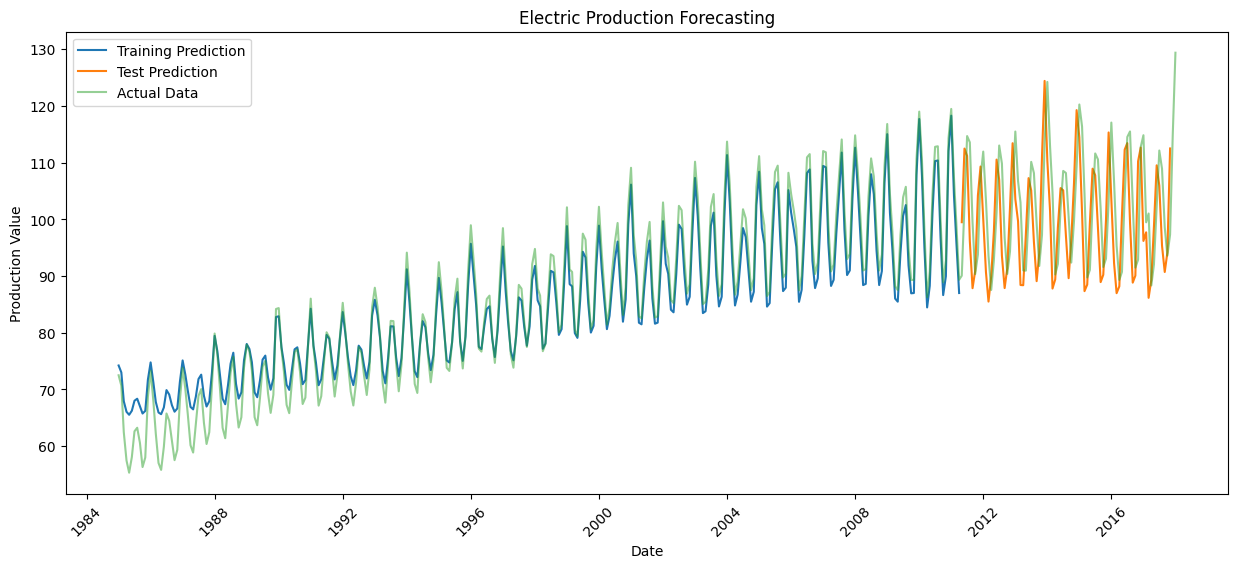

Train RMSE: 7.4510
Test RMSE: 10.0458


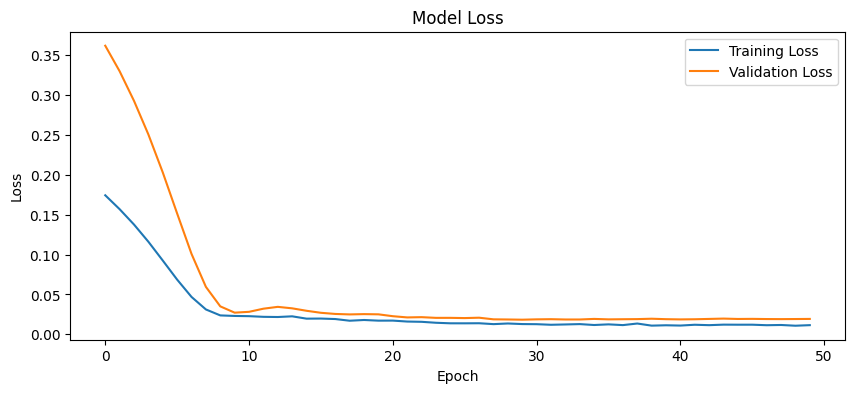

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from google.colab import files

# 1. Upload your dataset (commented out since you've already uploaded)
print("Please upload your CSV file (if not already uploaded):")
# uploaded = files.upload()  # Uncomment if you need to re-upload

# Load the dataset
# Using 'Electric_Production (1).csv' since Colab renamed it in your output
filename = 'Electric_Production (1).csv'  # Change to 'Electric_Production.csv' if not renamed
df = pd.read_csv(filename)

# 2. Prepare the data
# Column names based on typical electric production data (e.g., FRED dataset)
date_column = 'DATE'  # Common date column name
value_column = 'IPG2211A2N'  # Common value column for electric production; adjust if different

# Print columns for debugging
print("Columns in dataset:", df.columns.tolist())

# Convert date column to datetime and set as index
df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)

# Extract the time series data
time_series = df[value_column].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

# 3. Create sequences for time series
def prepare_data(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        seq = series[i:(i + n_steps)]
        X.append(seq)
        y.append(series[i + n_steps])
    return np.array(X), np.array(y)

# Parameters
n_steps = 1 # Look back 12 timesteps (e.g., 1 year for monthly data)
train_size = int(len(scaled_data) * 0.8)

# Split into train and test
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare training and testing data
X_train, y_train = prepare_data(train_data, n_steps)
X_test, y_test = prepare_data(test_data, n_steps)

# Reshape input for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 4. Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# 5. Train the model
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

# 6. Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Visualize results
plt.figure(figsize=(15, 6))
plt.plot(df.index[:len(train_predict)], train_predict, label='Training Prediction')
plt.plot(df.index[len(train_predict):len(train_predict) + len(test_predict)],
         test_predict, label='Test Prediction')
plt.plot(df.index, time_series, label='Actual Data', alpha=0.5)
plt.legend()
plt.title('Electric Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Production Value')
plt.xticks(rotation=45)
plt.show()

# 8. Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train_inv)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test_inv)**2))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()